# DoWhy: A Simple example
* source link: https://www.pywhy.org/dowhy/v0.8/example_notebooks/dowhy_simple_example.html

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

In [2]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_effect_modifiers=1,
    num_samples=5000,
    treatment_is_binary=True,
    stddev_treatment_noise=10,
    num_discrete_common_causes=1
)

df = data["df"]
df

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,-0.685045,1.0,0.906403,-1.970041,-0.563762,-0.065669,0.228772,2,True,8.271446
1,-0.540896,0.0,0.759473,-1.446085,0.143666,0.294779,0.636569,3,True,14.663730
2,-1.651696,1.0,0.615800,-2.808438,0.011460,0.150871,0.150328,3,True,8.090134
3,0.039676,1.0,0.612062,0.871200,1.086079,-0.499408,0.371191,2,True,15.994956
4,-1.280759,1.0,0.068672,-0.243195,-0.292950,-0.774648,0.943840,0,True,3.017169
...,...,...,...,...,...,...,...,...,...,...
4995,-0.435261,1.0,0.140675,0.157768,0.629252,0.010831,2.857508,0,True,10.110613
4996,-1.051430,0.0,0.293633,-2.101318,-0.650179,0.192295,-0.762501,1,True,5.572610
4997,-1.779205,0.0,0.535533,-0.728829,-0.373928,-1.028953,-0.125253,3,False,1.231878
4998,-2.344809,0.0,0.770469,-0.667712,0.174694,0.456477,1.460453,1,True,8.234961


In [3]:
print(data["dot_graph"])
print(data["gml_graph"])

digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}
graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]node[ id "X0" label "X0"] edge[ source "X0" target "y"]]


* pygraphviz install issue: solved by `conda` ([link](https://stackoverflow.com/questions/59707234/issues-installing-pygrahviz-fatal-error-c1083-cannot-open-include-file-graph))

In [4]:
# with graph

model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"]
)

model.view_model()

In [5]:
print(f"Treatment: {data['treatment_name']}")
print(f"Outcome: {data['outcome_name']}")

Treatment: ['v0']
Outcome: y


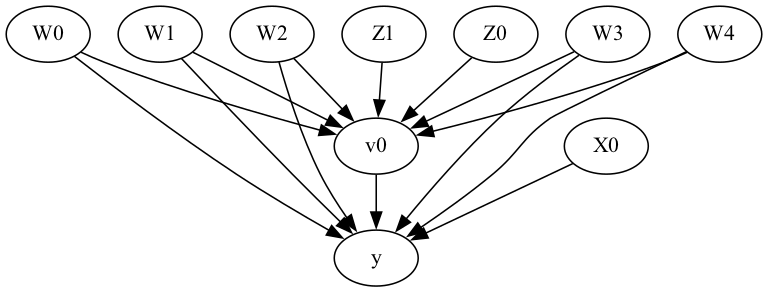

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W0,W1,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,W4,U) = P(y|v0,W3,W0,W1,W2,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [8]:
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print(f"Causal Estimate is {causal_estimate.value:.2f}")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W0,W1,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,W4,U) = P(y|v0,W3,W0,W1,W2,W4)

## Realized estimand
b: y~v0+W3+W0+W1+W2+W4
Target units: ate

## Estimate
Mean value: 8.3064620239554

Causal Estimate is 8.31


In [9]:
# Without graph
model= CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    effect_modifiers=data["effect_modifier_names"]
)

model.view_model()

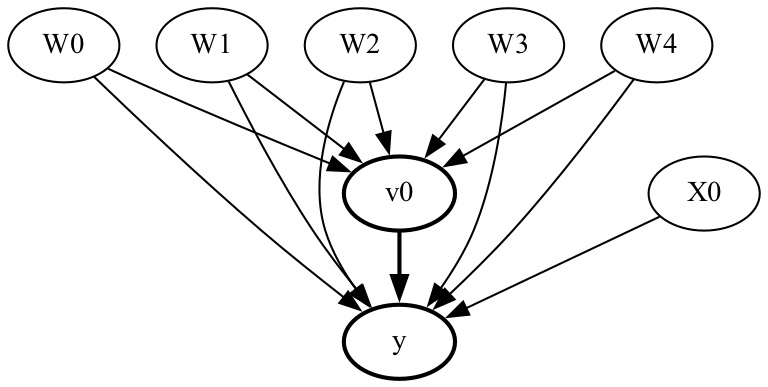

In [10]:
display(Image(filename="causal_model.png"))